In [3]:
#https://blog.csdn.net/tranquil666/article/details/134897385
from torch_geometric.datasets import KarateClub
import matplotlib.pyplot as plt 
import networkx as nx #用于把数据化成图的一个包
 
dataset = KarateClub()
 
'''
print(dataset) 
print(f'Dataset:{dataset}:')
print('===========================')
print(f'Number of graphs:{len(dataset)}') 
print(f'Number of features:{dataset.num_features}') 
print(f'Number of classes:{dataset.num_classes}') 
''' 
 
data = dataset[0] 
print(data) 
#邻接矩阵并不是n*n的，而是2*边的个数
edge_index = data.edge_index
print(edge_index.t())
 
def visualize_graph(G,color):
    plt.figure(figsize = (7,7)) 
    plt.xticks([]) 
    plt.yticks([]) 
    nx.draw_networkx(G,pos = nx.spring_layout(G,seed = 42),with_labels = False,
                     node_color=color ,cmap="Set2")
    plt.show()
    
def visualize_embedding(h,color,epoch = None,loss = None):
    plt.figure(figsize=(7,7)) 
    plt.xticks([])
    plt.yticks([]) 
    h = h.detach().cpu().numpy()
    plt.scatter(h[:,0] ,h[:,1],s = 140,c = color,cmap = "Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch:{epoch}.loss:{loss.item():.4f}',fontsize = 16) 
    plt.show()

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
 

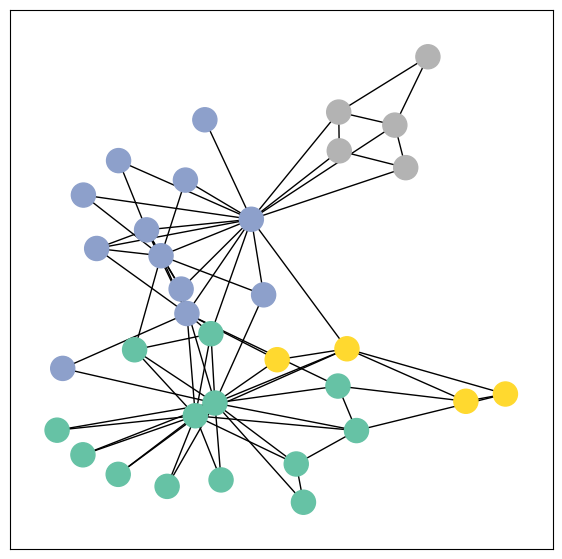

In [4]:
from torch_geometric.utils import to_networkx
G = to_networkx(data,to_undirected = True) 
visualize_graph(G,color = data.y)

In [5]:
#构造GCN函数
import torch 
from torch.nn import Linear 
from torch_geometric.nn import GCNConv 
 
class GCN(torch.nn.Module): 
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234) 
        self.conv1 = GCNConv(dataset.num_features,4) 
        self.conv2 = GCNConv(4,4) 
        self.conv3 = GCNConv(4,2) #做成二维向量方便画图展示
        
        self.classifier = Linear(2,dataset.num_classes) 
        
    def forward(self, x, edge_index):#这里可以对应之前说的，变得只有特征，而邻接矩阵是不变的
        h = self.conv1(x, edge_index) #x图，edge_index矩阵
        h = h.tanh()
        h = self.conv2(h,edge_index) 
        h = h.tanh()
        h = self.conv3(h,edge_index) 
        h = h.tanh()
        #h是一个中间结果，两维向量
        
        #分类层
        out = self.classifier(h) 
        
        return out , h 
 
model = GCN()
print(model)     

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


Embedding shape:[34, 2]


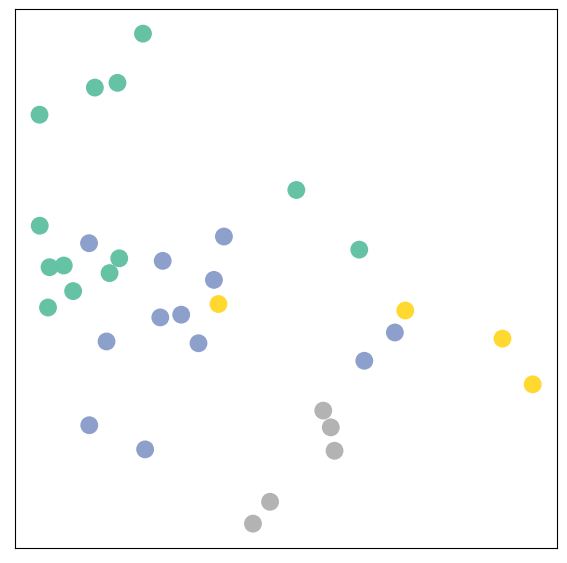

In [6]:
#输入特征的展示
model = GCN()
_,h = model(data.x, data.edge_index) 
print(f'Embedding shape:{list(h.shape)}') 
visualize_embedding(h,color = data.y) 
 
#开始是随机初始化的，看不出什么东西 

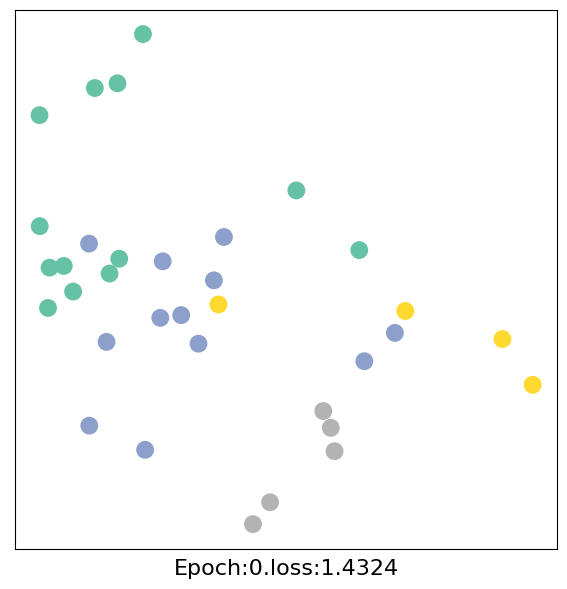

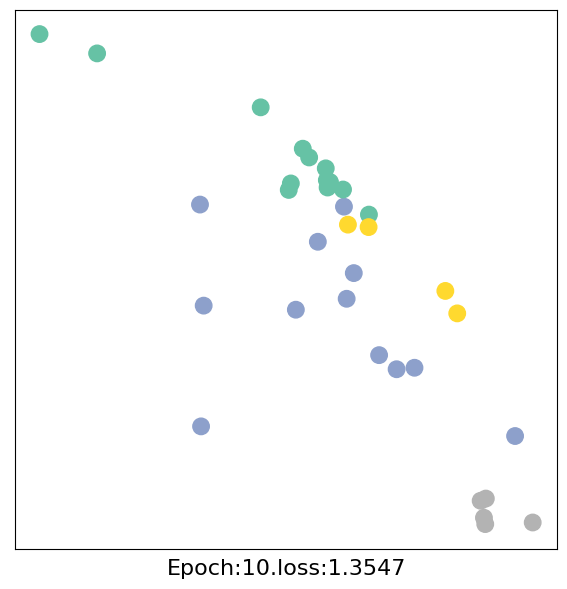

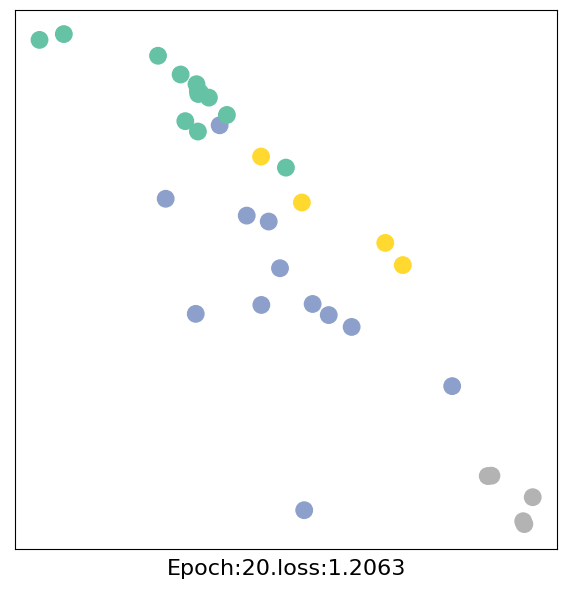

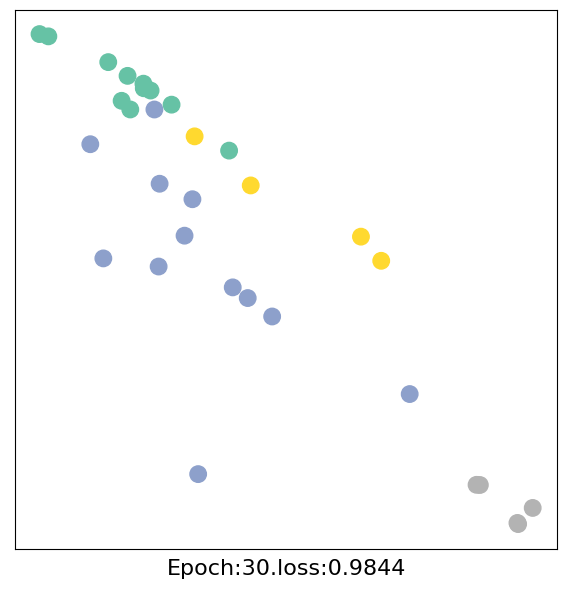

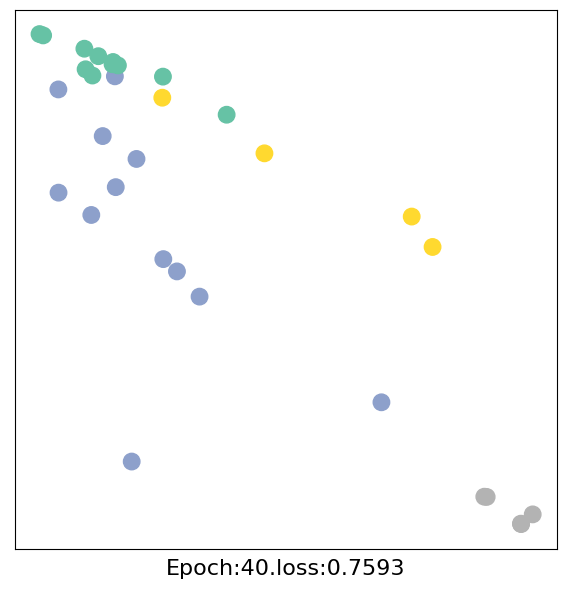

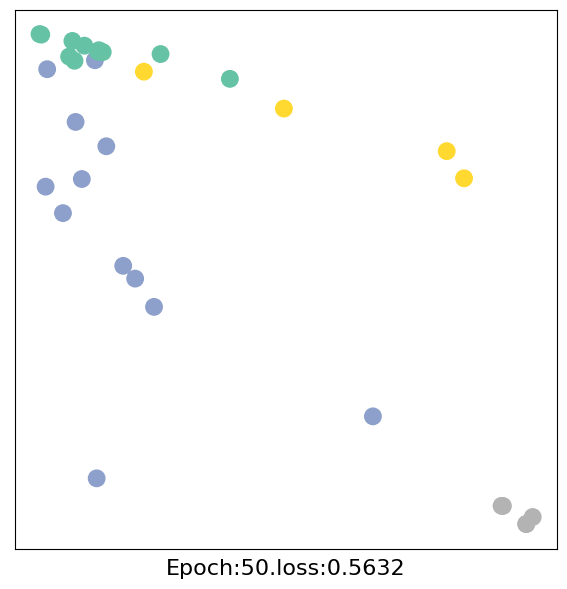

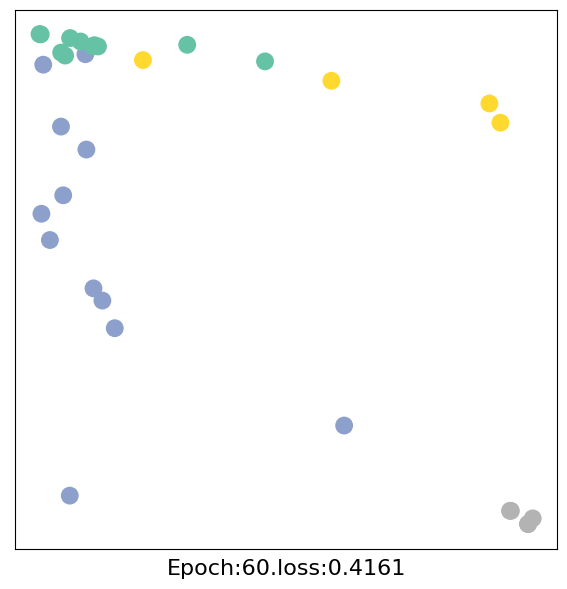

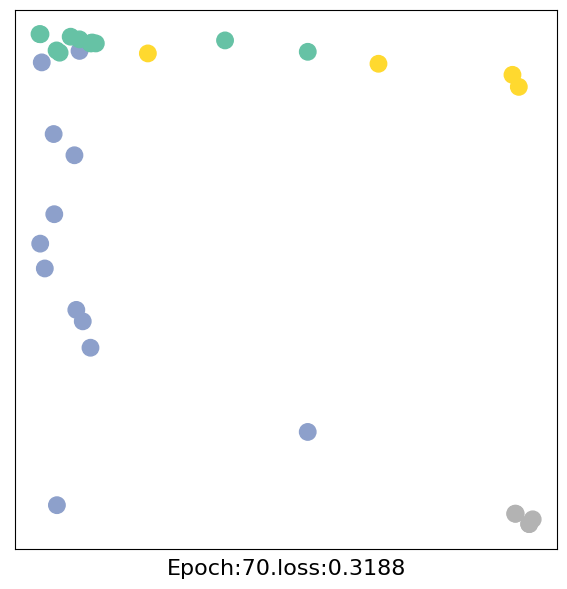

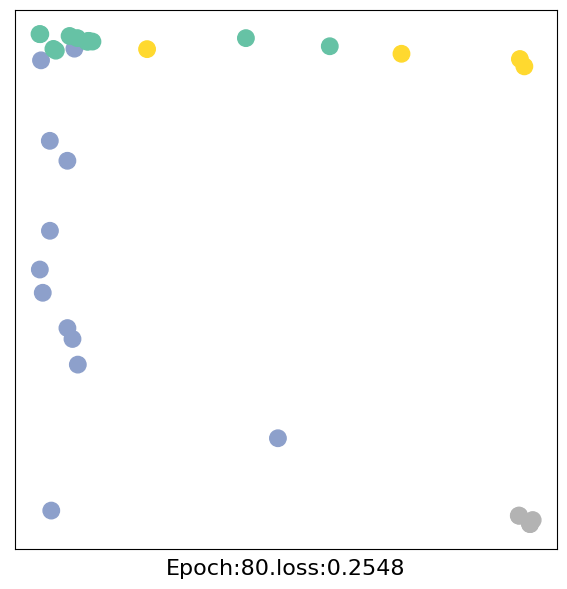

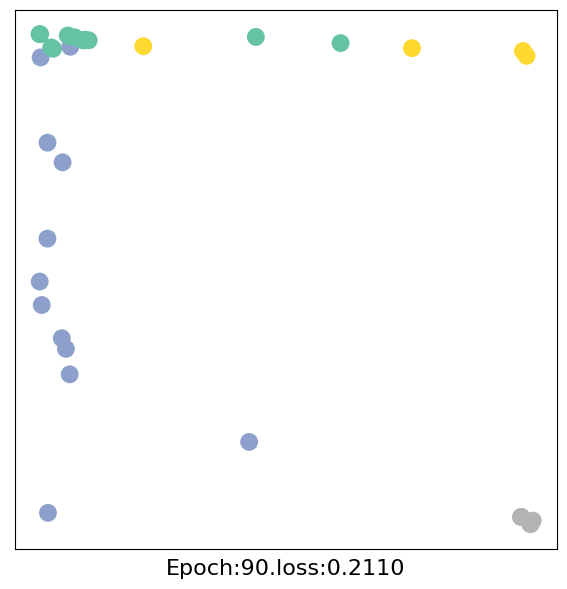

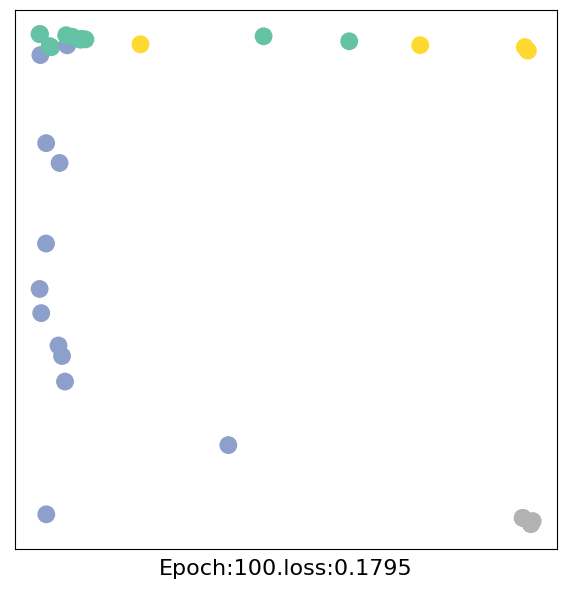

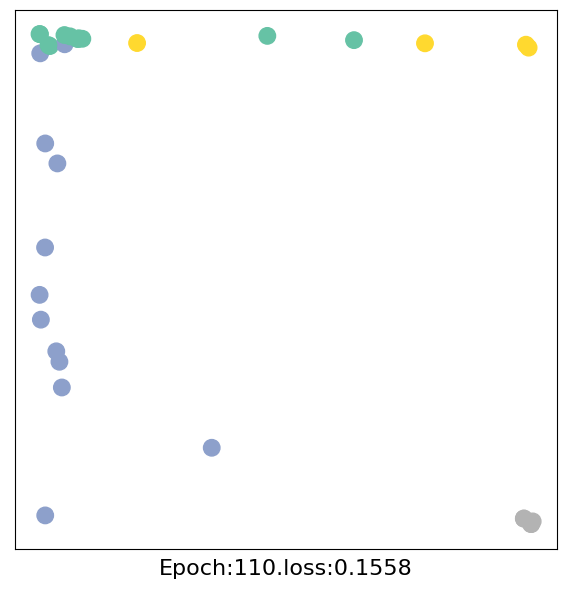

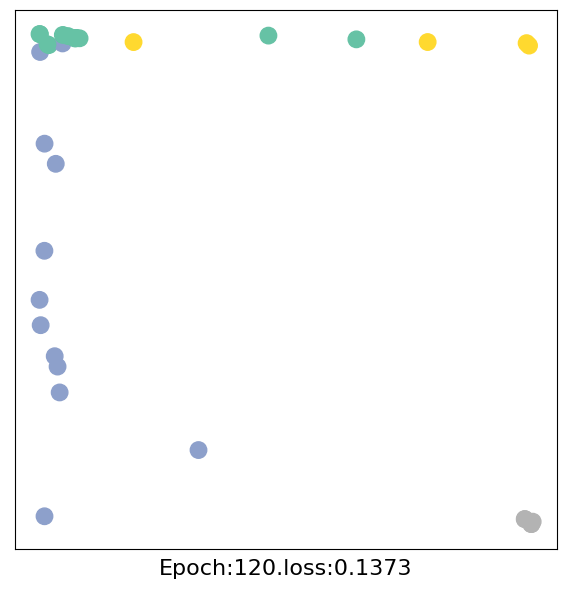

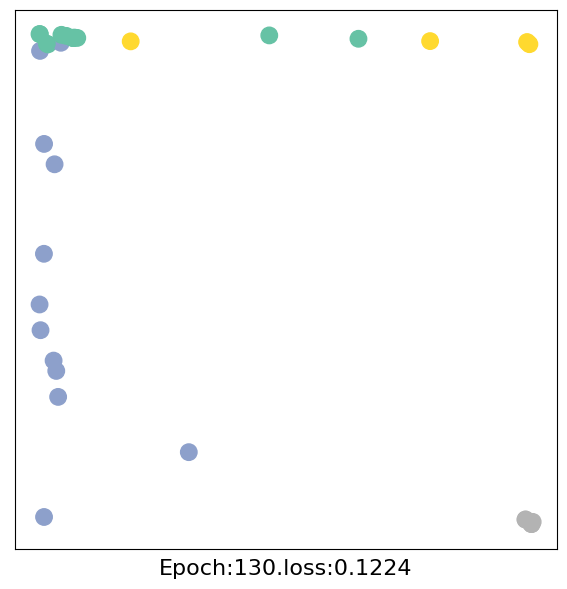

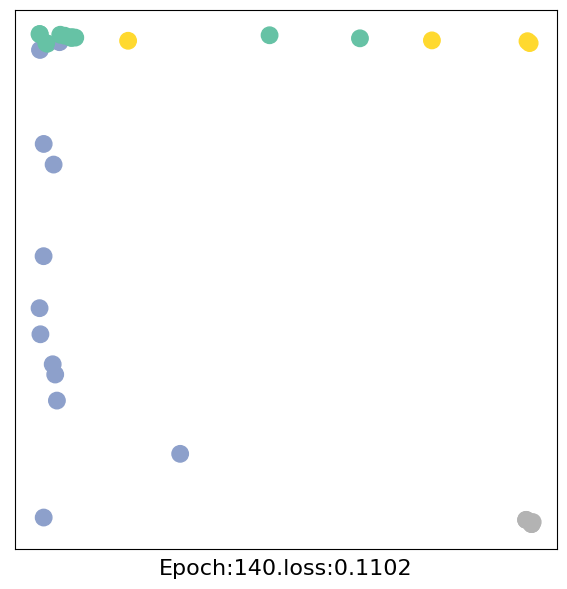

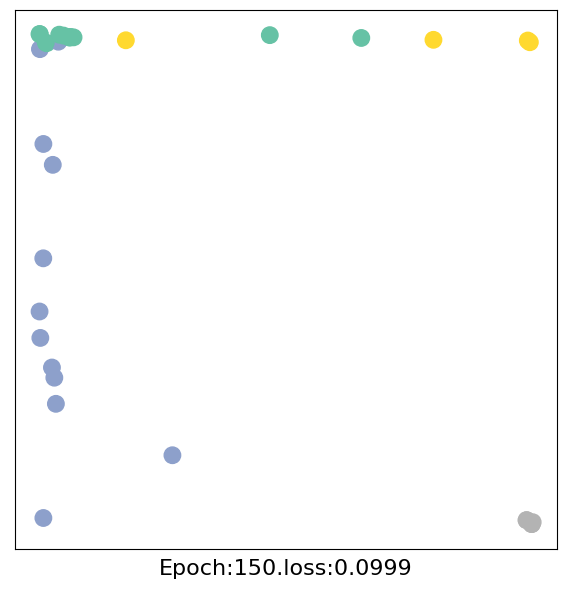

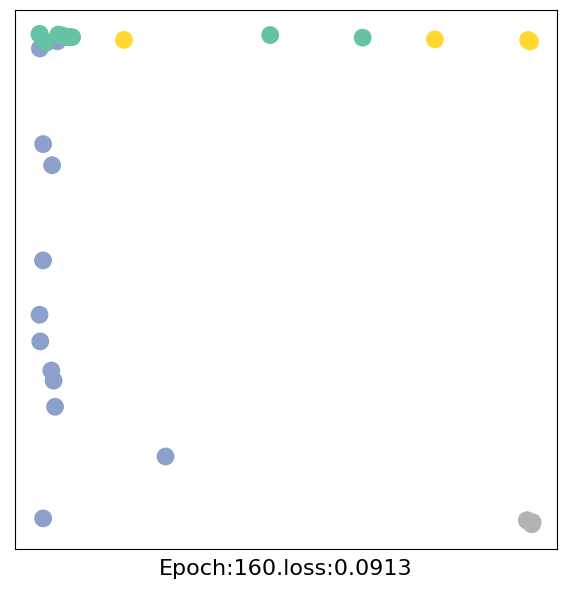

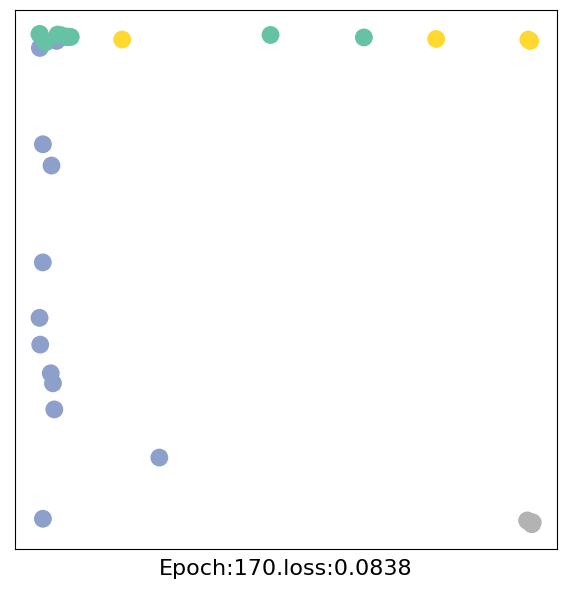

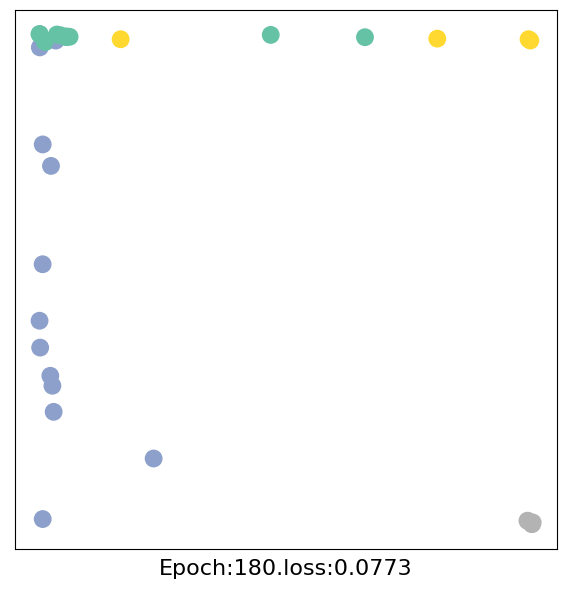

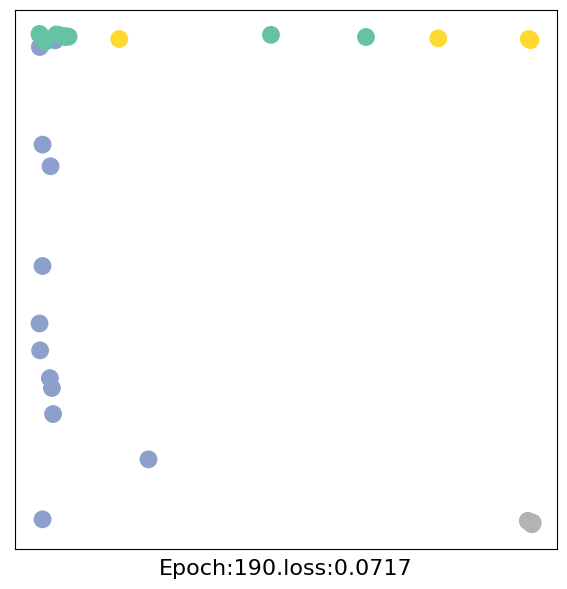

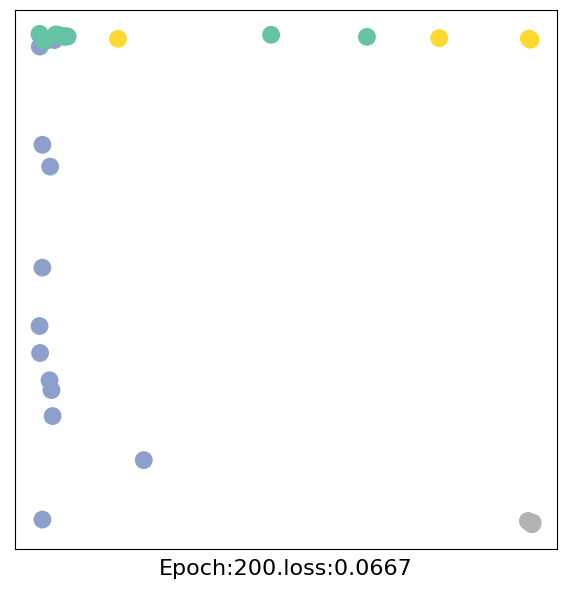

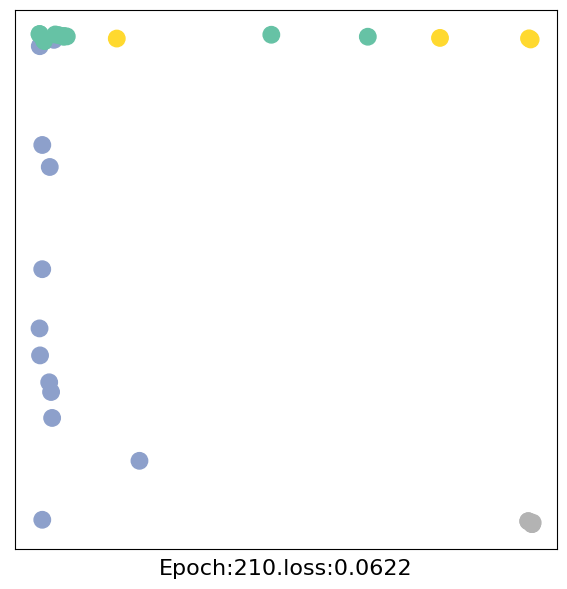

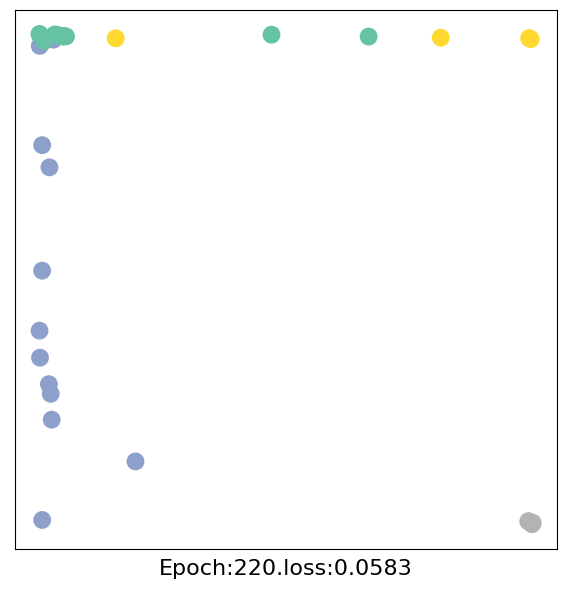

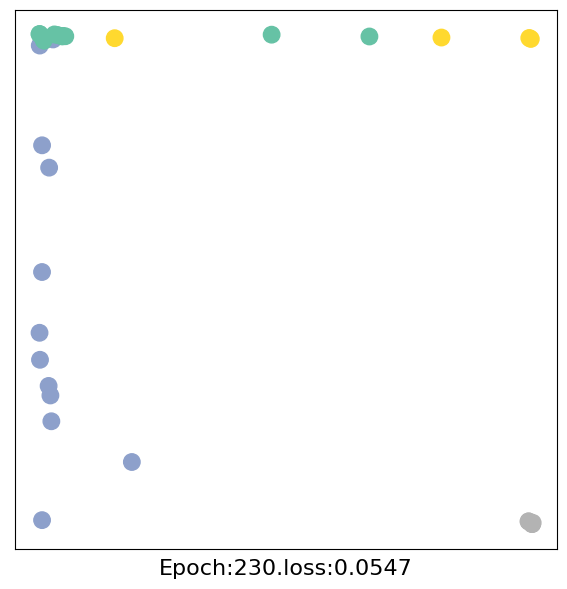

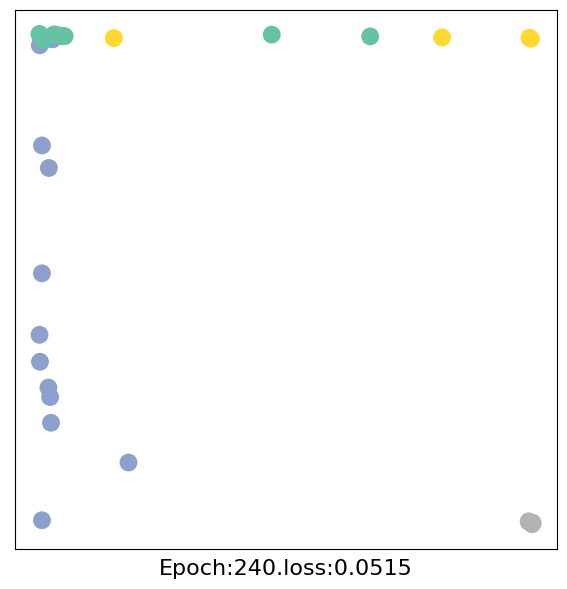

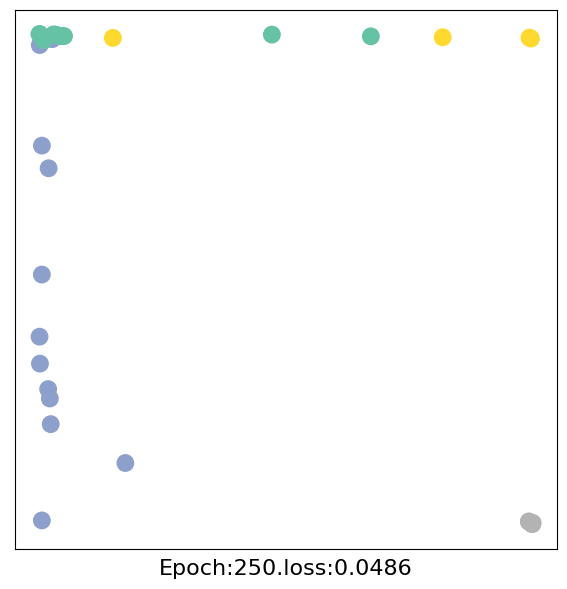

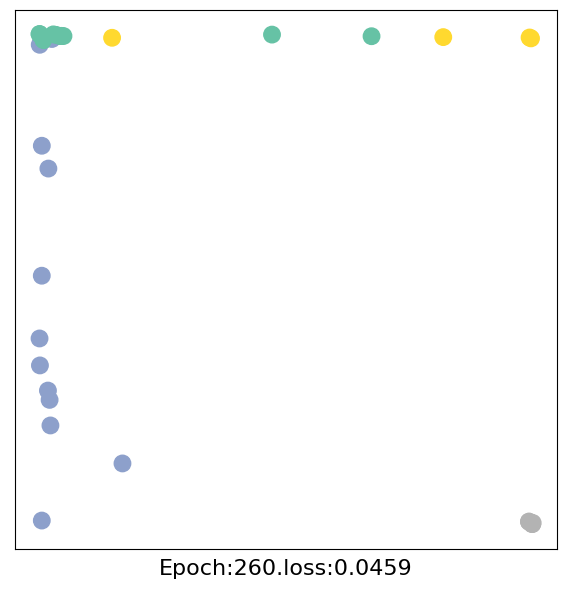

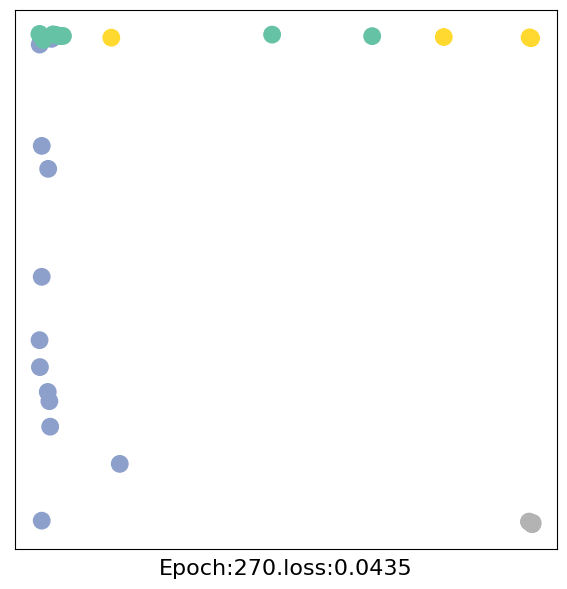

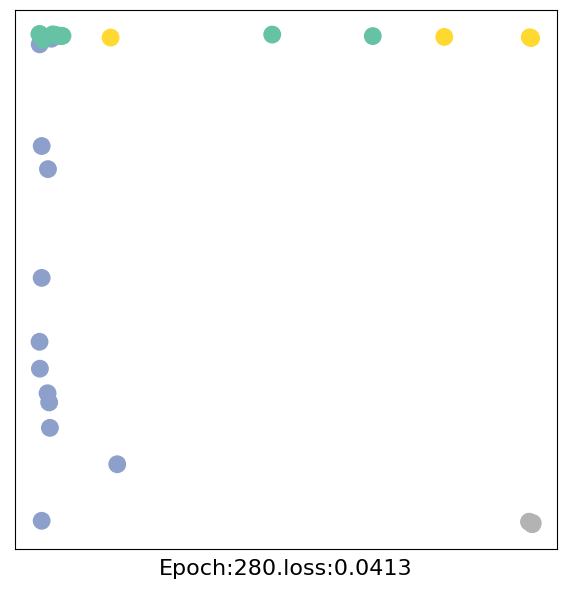

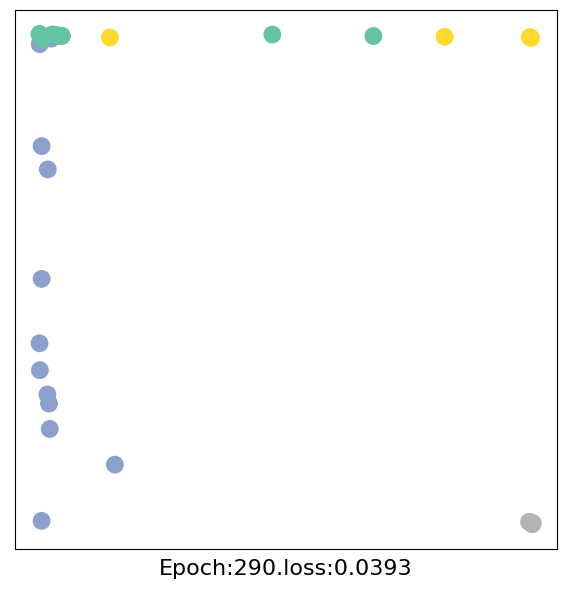

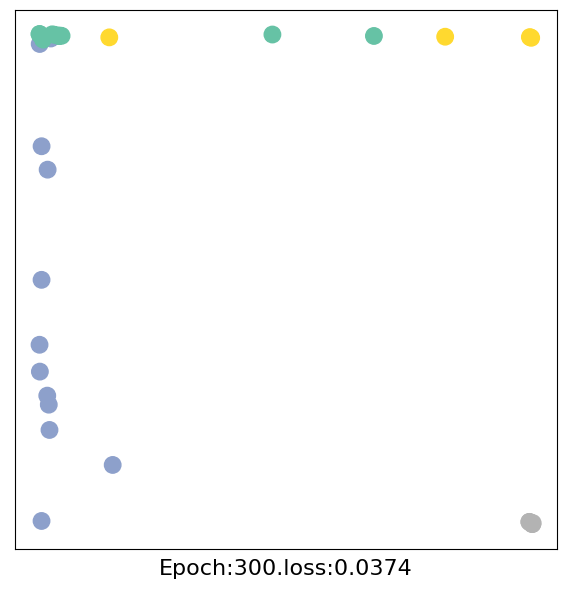

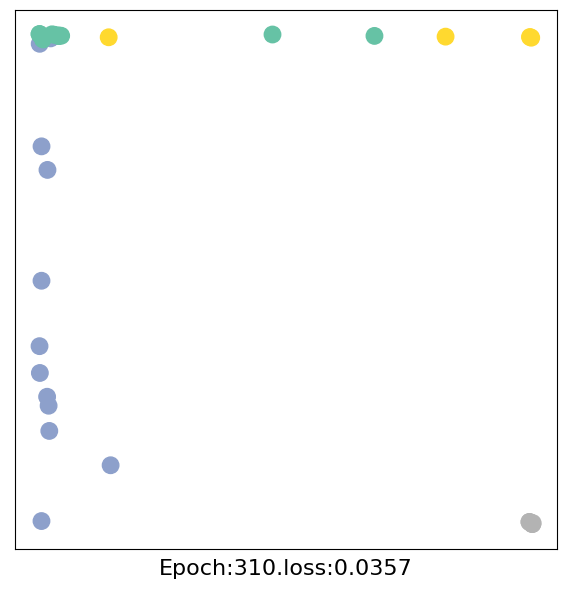

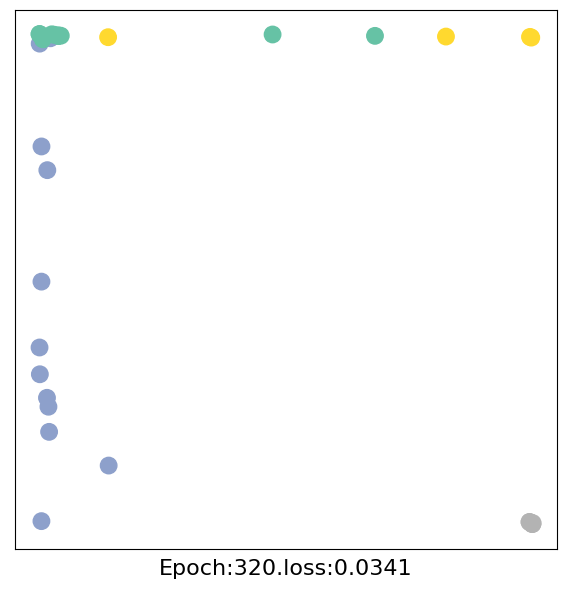

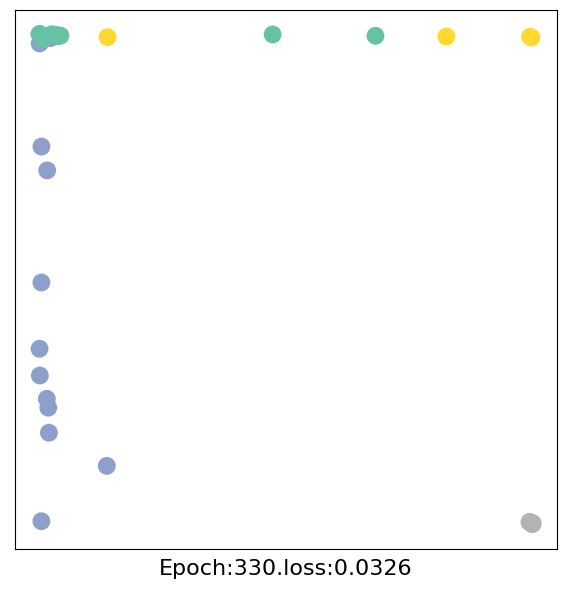

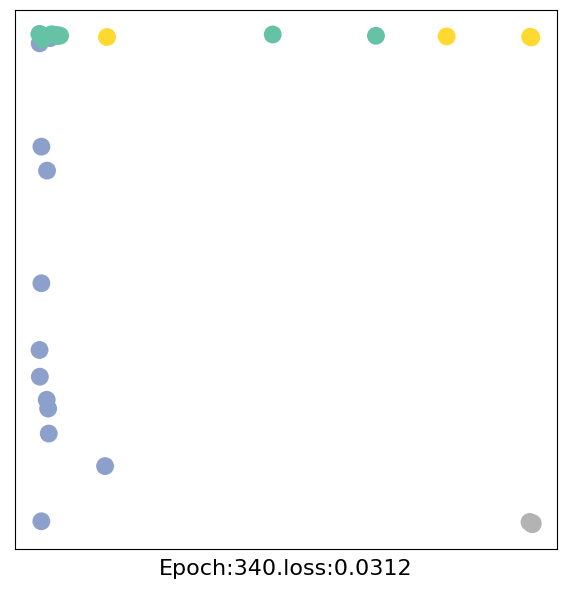

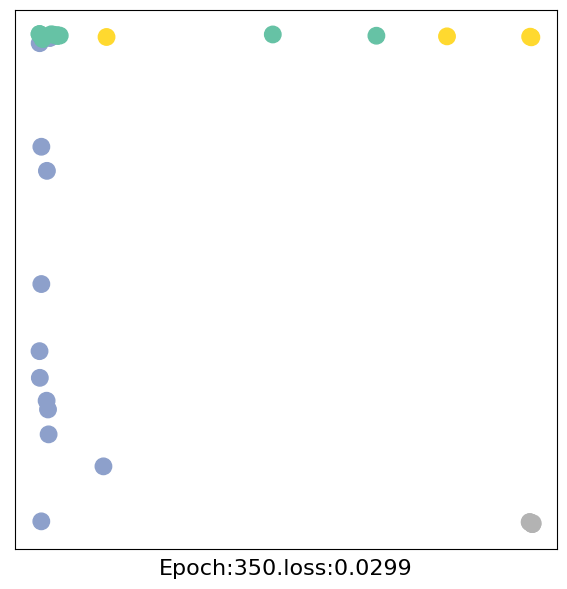

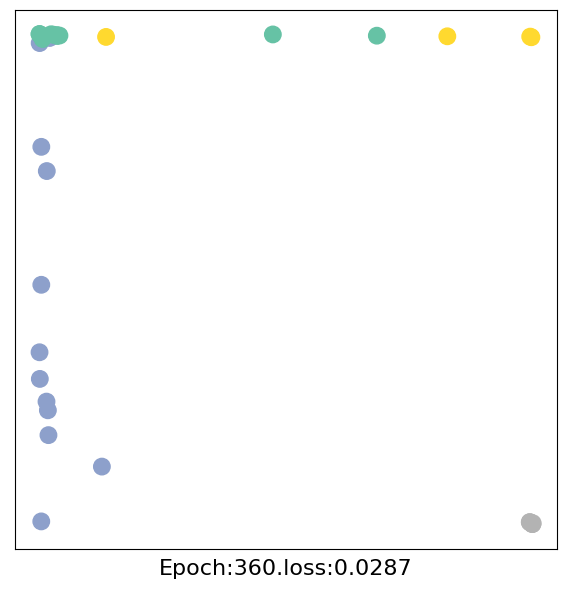

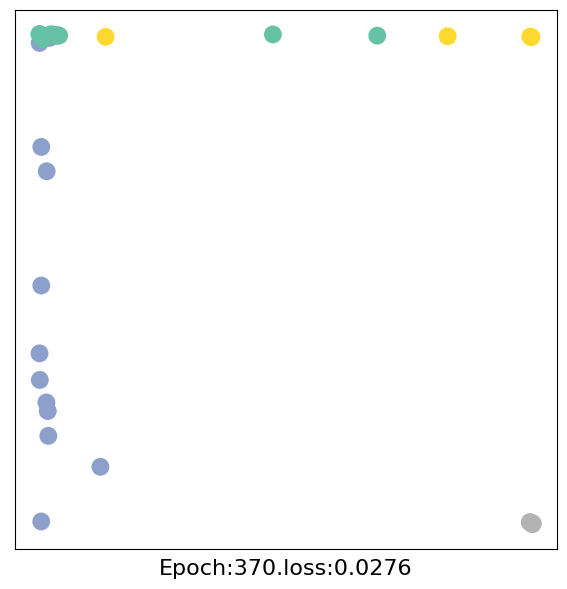

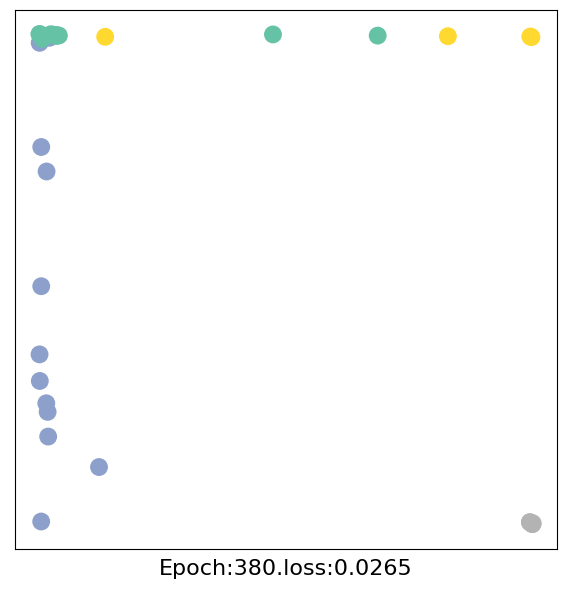

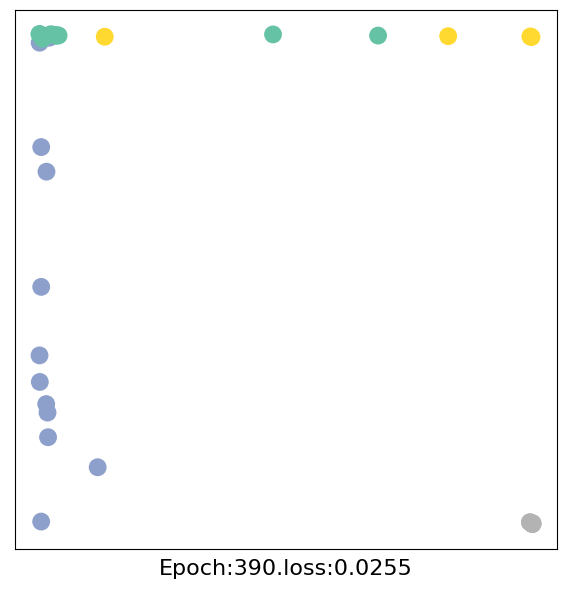

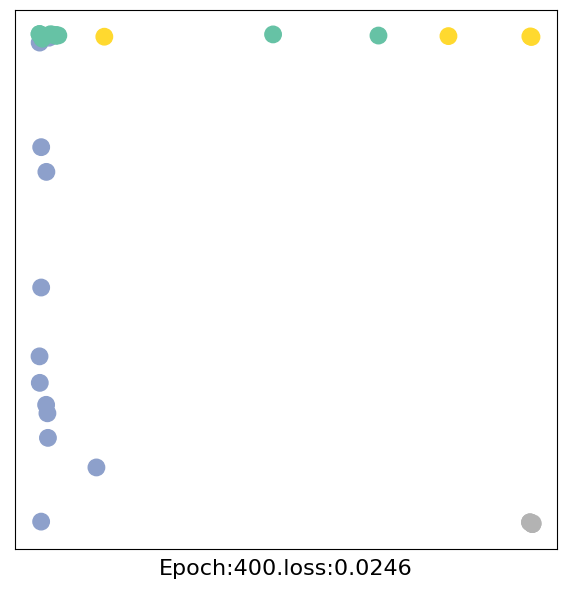

In [7]:
#训练模型(semi-supervised ：半监督) 
#只是中间网络结构用到了其他包，模型的构建还是十分熟悉的
import time 
model = GCN()
cirterion = torch.nn.CrossEntropyLoss() # define loss criterion
optimizer = torch.optim.Adam(model.parameters(),lr = 0.01) #define optimizer
 
def train(data):
    optimizer.zero_grad()
    out,h = model(data.x, data.edge_index)#h是中间输出的二维向量，主要是为了方便画图
    loss = cirterion(out[data.train_mask],data.y[data.train_mask]) 
    #注意：我们loss只关注有标签的有没有做好，其他的对我们没有什么影响（半监督的体现）
    loss.backward()
    optimizer.step()
    return loss, h 
 
for epoch in range(401):
    loss, h = train(data) 
    if epoch % 10 == 0:
        visualize_embedding(h,color = data.y, epoch = epoch, loss = loss) 
        time.sleep(0.3) 